<a href="https://colab.research.google.com/github/BingyuZhou/GAN/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
# !pip install tensorflow-gpu==2.0.0-alpha0

import tensorflow as tf
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.executing_eagerly())

2.0.0-alpha0
True


# GAN

MNIST dataset

(60000, 28, 28, 1)


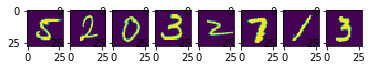

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train-128.0) / 128.0

x_train = x_train[..., tf.newaxis]

print(x_train.shape)

sample = np.random.choice(x_train.shape[0], size=8)
fig, axes = plt.subplots(1,8)

for i, s in enumerate(sample):
  axes[i].imshow(tf.squeeze(x_train[s]))




## Model

In [0]:
# Simple feedforward architecture
class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.d1 = tf.keras.layers.Dense(128, activation='relu')
    self.d2 = tf.keras.layers.Dense(128, activation='relu')
    self.d3 = tf.keras.layers.BatchNormalization()
    self.d4 = tf.keras.layers.Dense(28*28, activation='tanh')

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.d4(x)

class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.d1 = tf.keras.layers.Dense(256, activation='relu')
    self.d2 = tf.keras.layers.Dense(256, activation='relu')
    self.d3 = tf.keras.layers.Dropout(0.2)
    
    self.d4 = tf.keras.layers.Dense(1, activation=None)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)
    return tf.keras.activations.sigmoid(x), x

# Convolution architecture
class Generator_conv(Model):
  def __init__(self):
    super(Generator_conv, self).__init__()
    with tf.device("/gpu:0"):
      weight_decay = 2.5e-5
      self.d1 = tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
      self.d1_n = tf.keras.layers.BatchNormalization()
      self.d2 = tf.keras.layers.ReLU()
      self.d3 = tf.keras.layers.Dense(7*7*256, kernel_regularizer=tf.keras.regularizers.l2(weight_decay) )
      self.d3_n = tf.keras.layers.BatchNormalization()
      self.d4 = tf.keras.layers.ReLU()
      self.d5 = tf.keras.layers.Reshape((7, 7, 256))
      self.d6 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
      self.d6_n = tf.keras.layers.BatchNormalization()
      self.d7 = tf.keras.layers.ReLU()
      self.d8 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
      self.d8_n = tf.keras.layers.BatchNormalization()
      self.d9 = tf.keras.layers.ReLU()
      self.d10 = tf.keras.layers.Conv2D(filters=1, kernel_size=4, activation="tanh", padding="same", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
  
  def call(self, x, is_training):
    x = tf.cast(x, tf.float32)
    x = self.d1(x)
    x = self.d1_n(x, is_training)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d3_n(x, is_training)
    x = self.d4(x)
    x = self.d5(x)
    x = self.d6(x)
    x = self.d6_n(x, is_training)
    x = self.d7(x)
    x = self.d8(x)
    x = self.d8_n(x, is_training)
    x = self.d9(x)
    
    return self.d10(x)

class Discriminator_conv(Model):
  def __init__(self):
    super(Discriminator_conv, self).__init__()
    with tf.device("/gpu:0"):
      weight_decay = 2.5e-5
      self.d1 = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay), bias_regularizer=tf.keras.regularizers.l2(weight_decay))
#       self.d2 = tf.keras.layers.LeakyReLU(alpha=0.01)
      self.p1 = tf.keras.layers.Dropout(0.1)
      self.d3 = tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay), bias_regularizer=tf.keras.regularizers.l2(weight_decay))
#       self.d4 = tf.keras.layers.LeakyReLU(alpha=0.01)
      self.p2 = tf.keras.layers.Dropout(0.1)
      self.d5 = tf.keras.layers.Flatten()
      self.d6 = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay), bias_regularizer=tf.keras.regularizers.l2(weight_decay))
#       self.d7 = tf.keras.layers.BatchNormalization()
      
#       self.d8 = tf.keras.layers.LeakyReLU(alpha=0.01)
#       self.p3 = tf.keras.layers.Dropout(0.1)
      
      self.d9 = tf.keras.layers.Dense(1, activation=None)
  
  def call(self, x):
    x = tf.cast(x, tf.float32)
    x = self.d1(x)
#     x = self.d2(x)
    x = self.p1(x)
    x = self.d3(x)
#     x = self.d4(x)
    x = self.p2(x)
    x = self.d5(x)
    x = self.d6(x)
#     x = self.d7(x, True)
#     x = self.d8(x)
#     x = self.p3(x)
    
    return self.d9(x)
    

generator = Generator_conv()
discriminator = Discriminator_conv()
  

## Optimizer and loss

In [0]:
def loss_discriminator(sample_data, sample_generator):
  pred_data_logits = discriminator(sample_data)
  pred_gen_logits = discriminator(sample_generator)
  
#   loss_dis = -tf.reduce_mean(tf.math.log(pred_data)+tf.math.log(1.0-pred_generator))
  loss_data = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(pred_data_logits), logits=pred_data_logits))
  loss_gen_sample = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(pred_gen_logits), logits=pred_gen_logits))
  loss_dis = loss_data+loss_gen_sample
  
  
  return loss_dis

def loss_generator(sample):
#   loss = -tf.reduce_mean(tf.math.log(discriminator(sample)))
  pred_logits = discriminator(sample)
  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(pred_logits), logits=pred_logits))
  
  return loss

def loss_dis_wass(sample_data, sample_generator, lam):
  pred_data_logits = discriminator(sample_data)
  pred_gen_logits = discriminator(sample_generator)
  
  loss_dis = tf.reduce_mean(pred_gen_logits) - tf.reduce_mean(pred_data_logits)
  
  # gradient penalty
  epsilon = tf.random.uniform(shape=(BATCH_SIZE,1,1,1), minval=0, maxval=1.0)
  diff = sample_generator - sample_data
  interpolation = sample_data + epsilon*diff
  g = tf.gradients(discriminator(interpolation), [interpolation])
  EPS = 1e-10
  slopes = tf.sqrt(tf.reduce_sum(tf.square(g), axis=[1,2,3])+EPS)
  loss_dis += lam*tf.reduce_mean((slopes - 1.0)**2)
  return loss_dis

def loss_gen_wass(sample):
  pred_logits = discriminator(sample)
  loss = -tf.reduce_mean(pred_logits)
  return loss
  
optimizer_dis = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
optimizer_gen = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)


## Train

In [0]:
BATCH_SIZE = 32
INPUT_FEATURE = 64




def uniform_sample(m, n):
  return np.random.uniform(-1.0, 1.0, size=(m,n))

def norm_sample(m, n):
  return np.random.normal(size=(m,n))

def f_grad_dis(discriminator, sample, sample_gen):
  with tf.GradientTape() as g_dis:
      loss_dis = loss_dis_wass(sample, sample_gen, 1.0)
  return loss_dis, g_dis.gradient(loss_dis, discriminator.trainable_variables)
  
  
  

@tf.function
def train_step():
  ind = np.random.choice(x_train.shape[0], size=BATCH_SIZE)
  sample = x_train[ind,:]
  
  sample_gen = generator(norm_sample(BATCH_SIZE, INPUT_FEATURE), True)

  loss_dis, grad_dis = f_grad_dis(discriminator, sample, sample_gen)

  optimizer_dis.apply_gradients(zip(grad_dis, discriminator.trainable_variables))

  ls_dis.update_state(loss_dis)
   
  with tf.GradientTape()as g_gen:
    sample_gen = generator(norm_sample(BATCH_SIZE, INPUT_FEATURE), True)
    loss_gen = loss_gen_wass(sample_gen)
  
  grad_gen = g_gen.gradient(loss_gen, generator.trainable_variables)
  optimizer_gen.apply_gradients(zip(grad_gen, generator.trainable_variables))
  
  ls_gen.update_state(loss_gen)
  
  
  return loss_dis, loss_gen
  
  
  
  
    
    
  

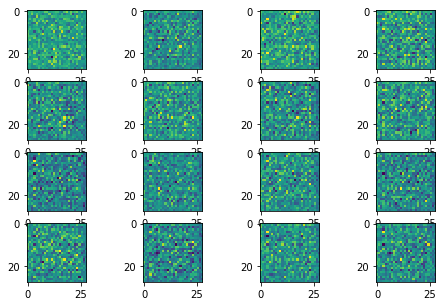

ls_gen -2.7547717094421387 ls_dis -1.3935842514038086


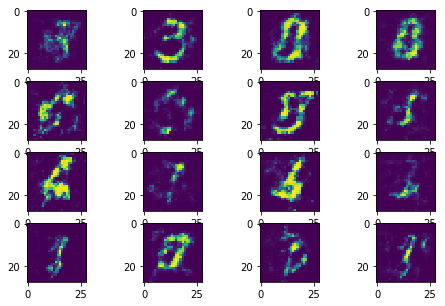

ls_gen -2.663567543029785 ls_dis -2.638801336288452


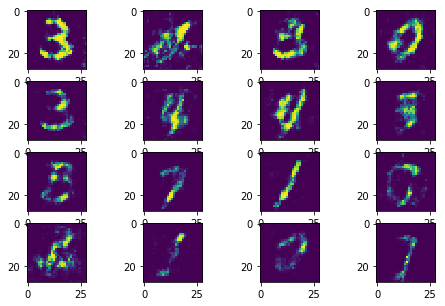

ls_gen -3.1980865001678467 ls_dis -3.3861048221588135


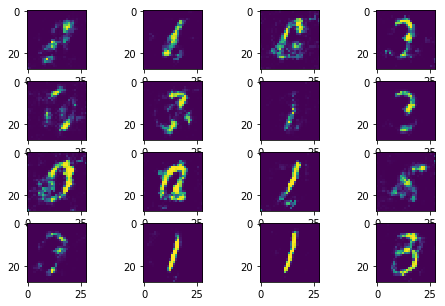

ls_gen -3.4594838619232178 ls_dis -3.966538906097412


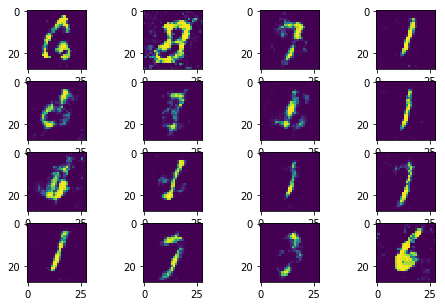

ls_gen -3.778196334838867 ls_dis -4.3660807609558105


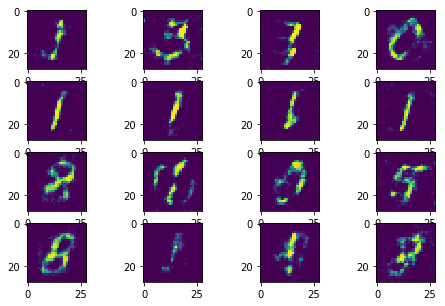

ls_gen -3.860893487930298 ls_dis -4.591104030609131


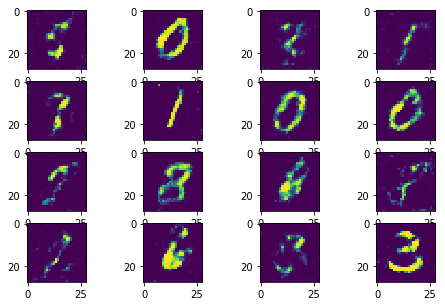

ls_gen -3.5433239936828613 ls_dis -4.472891807556152


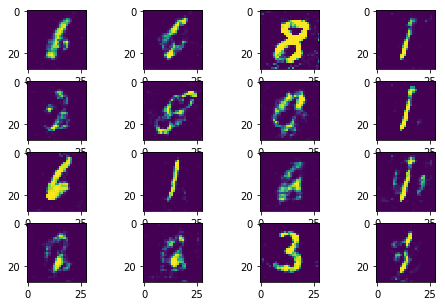

ls_gen -3.7260446548461914 ls_dis -4.846893310546875


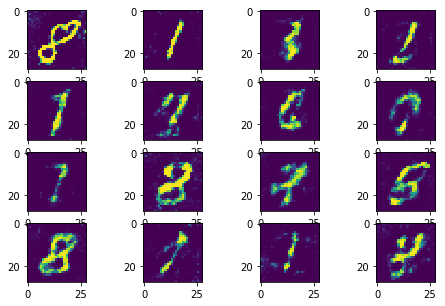

ls_gen -3.9217309951782227 ls_dis -4.908684730529785


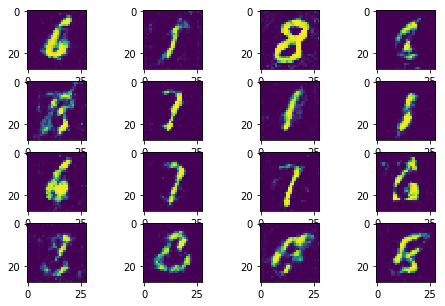

ls_gen -4.046864032745361 ls_dis -5.317192554473877


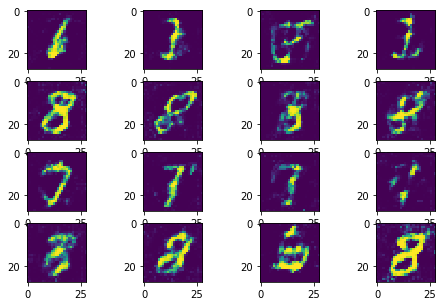

ls_gen -4.237509250640869 ls_dis -5.5272016525268555


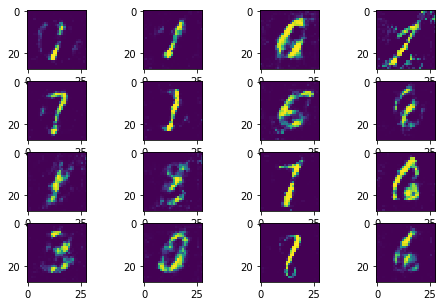

ls_gen -4.485013961791992 ls_dis -5.629749774932861


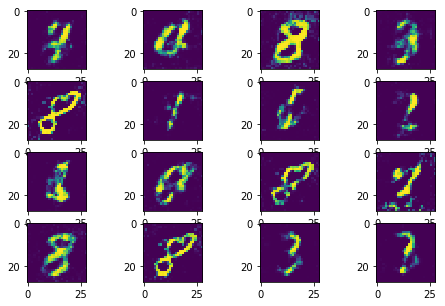

ls_gen -4.417859077453613 ls_dis -5.570535182952881


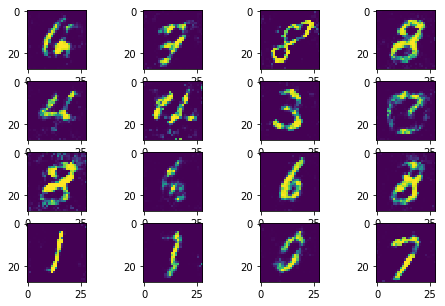

ls_gen -4.45268440246582 ls_dis -5.54827880859375


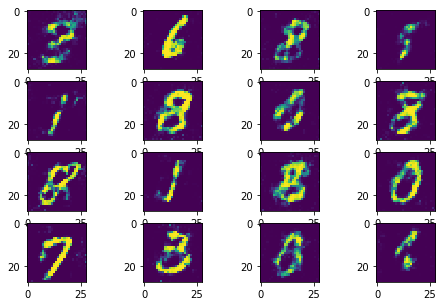

ls_gen -3.658402681350708 ls_dis -4.889817714691162


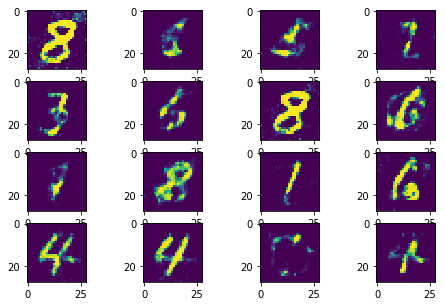

ls_gen -3.71798038482666 ls_dis -5.4434428215026855


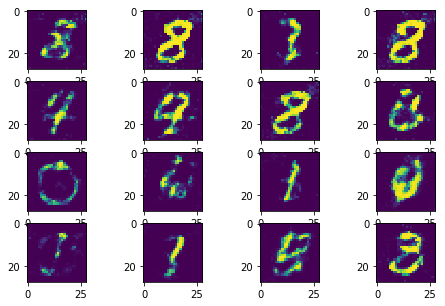

ls_gen -4.10082483291626 ls_dis -5.835874557495117


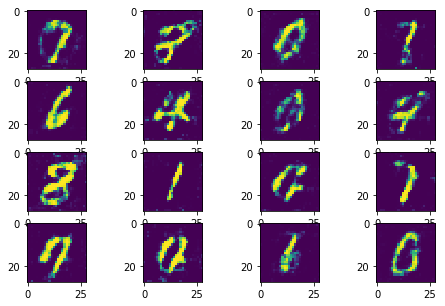

ls_gen -4.259462356567383 ls_dis -6.0539655685424805


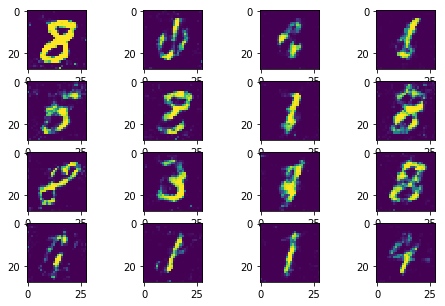

ls_gen -4.538974761962891 ls_dis -6.233678817749023


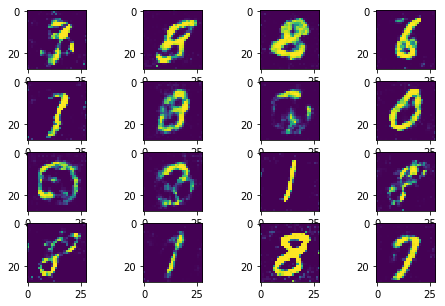

ls_gen -4.697430610656738 ls_dis -6.320804595947266


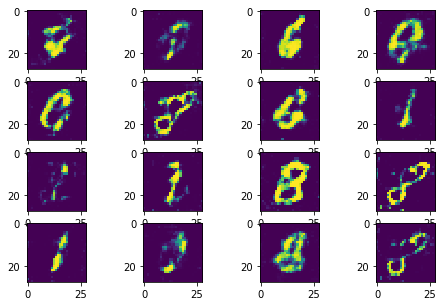

ls_gen -4.4606547355651855 ls_dis -6.213176250457764


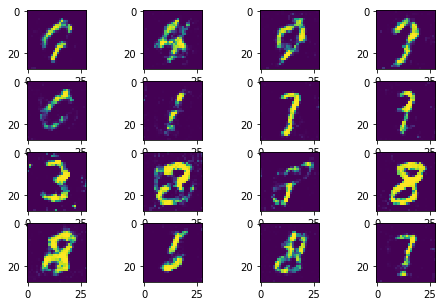

ls_gen -3.826939105987549 ls_dis -5.665740489959717


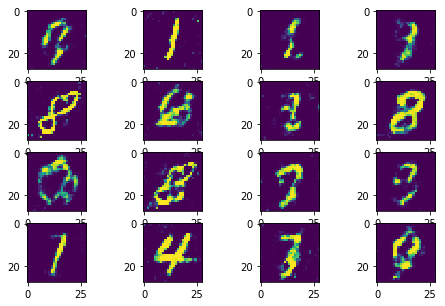

ls_gen -3.4205620288848877 ls_dis -5.5771098136901855


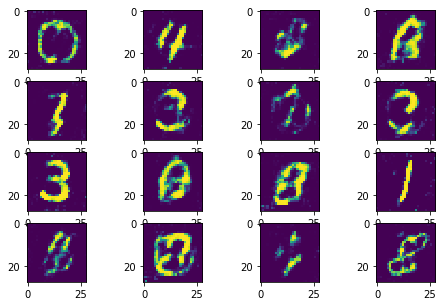

ls_gen -3.442026138305664 ls_dis -5.914791107177734


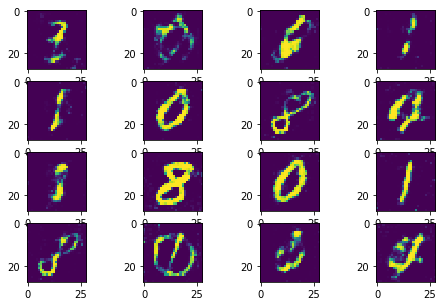

ls_gen -3.9839260578155518 ls_dis -6.2833147048950195


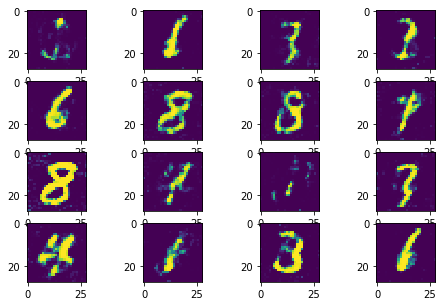

ls_gen -3.9481585025787354 ls_dis -6.0611162185668945


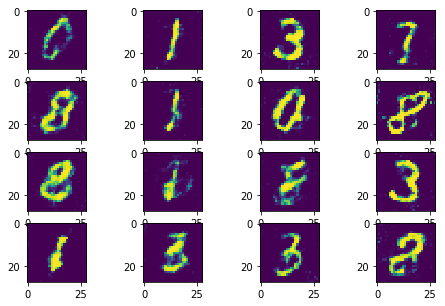

ls_gen -1.9642646312713623 ls_dis -3.5929839611053467


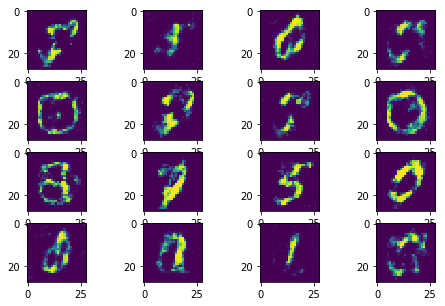

ls_gen -0.9823358654975891 ls_dis -4.024535655975342


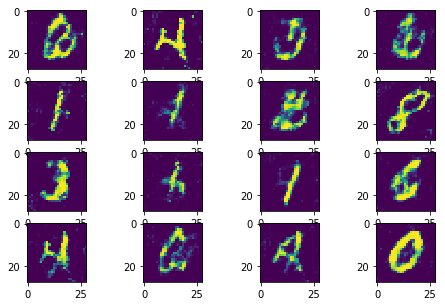

ls_gen -0.9539502859115601 ls_dis -4.197277069091797


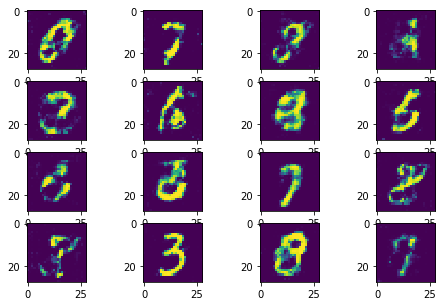

ls_gen -0.9366338849067688 ls_dis -4.358201026916504


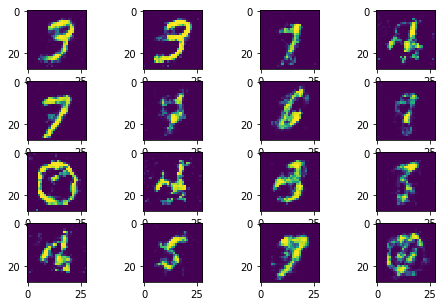

In [0]:
ls_gen = tf.keras.metrics.Mean(name='ls_gen')
ls_dis = tf.keras.metrics.Mean(name='ls_dis')

def plot(sample):
  f, ax = plt.subplots(4,4, figsize=(8,5))
  for i, s in enumerate(sample):
    ax[int(i/4)][i%4].imshow(tf.squeeze(s))
  
  plt.show()
    

samples = generator(norm_sample(16, INPUT_FEATURE), False)
plot(samples.numpy())

for ep in range(30):
  for i in range(200):
    loss_dis, loss_gen = train_step()
    ls_gen.update_state(loss_gen)
    ls_dis.update_state(loss_dis)
    
    
  tf.print("ls_gen {} ls_dis {}".format(ls_gen.result(), ls_dis.result()))
  
  samples = generator(norm_sample(16, INPUT_FEATURE), False)
  plot(samples.numpy())
  
  ls_gen.reset_states()
  ls_dis.reset_states()
    

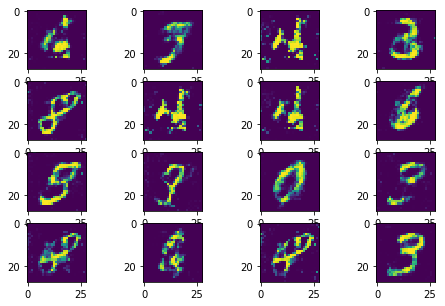

In [0]:


ind = np.random.choice(28*28, 100, replace=False)
z = x_train[:16,].reshape((-1, 28*28))[:,ind]
samples = generator(norm_sample(16, INPUT_FEATURE), False)
plot(samples.numpy())


In [0]:
tf.sigmoid(discriminator(samples))

<tf.Tensor: id=70661, shape=(16, 1), dtype=float32, numpy=
array([[0.19772917],
       [0.10071051],
       [0.18592575],
       [0.75870323],
       [0.86763334],
       [0.16555622],
       [0.1733954 ],
       [0.10336578],
       [0.15646333],
       [0.1425583 ],
       [0.07011384],
       [0.07735437],
       [0.1399605 ],
       [0.30080688],
       [0.2995026 ],
       [0.13478613]], dtype=float32)>